In [3]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import matplotlib as mpl
from scipy.interpolate import make_interp_spline, BSpline
import pyvista as pv
import seaborn as sns
from scipy.stats import mannwhitneyu

plt.style.use('seaborn-v0_8-ticks')

mpl_config = pd.read_csv('../../mpl_config.csv').to_dict(orient='records')[0]

mpl.rcParams.update(mpl_config)


In [4]:
def standardize(M) :   
    """ Standardization by column for 2D matrices """
    
    M_copy = np.copy(M)
    M_copy = M_copy.astype(float)
    for j in range(np.shape(M)[1]) :
        if np.std(M[:,j],axis=0) != 0 :
            M_copy[:,j] = (M[:,j].astype(float) - float(np.mean(M[:,j],axis=0)))/float(np.std(M[:,j],axis=0))
        else : 
            M_copy[:,j] = M[:,j].astype(float) - float(np.mean(M[:,j],axis=0))
            
    return M_copy

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)


def angle_between(v1, v2, directed = False):
    """ Returns the angle in radians between vectors 'v1' and 'v2'"""
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    delta = np.arccos(np.dot(v1_u, v2_u))*180/np.pi

    if not directed : 
        if delta > 90 :
            delta = 180 - delta
    return delta

def smooth(x,y,nb_point) :
    """Smooth a (x,y) serie by inserting nb_point with spline interpolation"""
    x_smooth = np.linspace(np.min(x), np.max(x), nb_point) 
    y_smooth = make_interp_spline(x, y, k=3)(x_smooth)

    return x_smooth, y_smooth

def produce_trial_index(d) :
    """Produce a dictionnary of trial indices corresponding to each label."""
    
    trial_idx = None
    
    go_hit_idx = (d['Choice'] == 1)&(d['Category ID'] == 2)&(d['Context'] == 0)
    go_error_idx = (d['Choice'] == 1)&(d['Category ID'] == 1)&(d['Context'] == 0)

    nogo_hit_idx = (d['Choice'] == -1)&(d['Category ID'] == 1)&(d['Context'] == 0)
    nogo_error_idx = (d['Choice'] == -1)&(d['Category ID'] == 2)&(d['Context'] == 0)

    right_hit_idx = (d['Choice'] == 1) & (d['Category ID'] == 2)&(d['Context'] == 1)
    left_hit_idx = (d['Choice'] == -1) & (d['Category ID'] == 1)&(d['Context'] == 1)

    right_error_idx = (d['Choice'] == 1) & (d['Category ID'] == 1)&(d['Context'] == 1)
    left_error_idx = (d['Choice'] == -1) & (d['Category ID'] == 2)&(d['Context'] == 1)

    # Snooze : The animal did not respond in the 2AFC paradigm.
    snooze_right_idx = (d['Choice'] == 0)&(d['Category ID'] == 2)&(d['Context'] == 1)
    snooze_left_idx = (d['Choice'] == 0)&(d['Category ID'] == 1)&(d['Context'] == 1)

    trial_idx = {'Go / Go : Hit' : go_hit_idx, 'Go / Nogo : Miss':nogo_error_idx, 'NoGo / NoGo : CR' : nogo_hit_idx , \
              'NoGo / Go : FA' : go_error_idx,  'Left / Left':left_hit_idx, 'Left / Right':left_error_idx, 'Left / Snooze':snooze_left_idx, \
           'Right / Right':right_hit_idx, 'Right / Left':right_error_idx, 'Right / Snooze':snooze_right_idx}

    return trial_idx

In [5]:
## We load here the selected ridge and PCA models

with open('Models/ridge.pickle', 'rb') as f:
    ridge_output = pickle.load(f)
"""
with open('Models/ridge_lick.pickle', 'rb') as f:
    ridge_output = pickle.load(f)
    
with open('Models/sel_mat_hybrid.pickle', 'rb') as f: 
    S = pickle.load(f)
"""

with open('Models/pca_notime.pickle', 'rb') as f:
    pca1 = pickle.load(f)

with open('Models/pca_time.pickle', 'rb') as f:
    pca2 = pickle.load(f)

with open('../DATA/Dataframes/df_pseudo.pickle', 'rb') as f:
    merged_data = pickle.load(f)


res = ridge_output['Models']
reg_scores = ridge_output['Scores']

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.2.2 when using version 1.6.1. This might lead to breaking code or inv

### Selectivity matrix construction

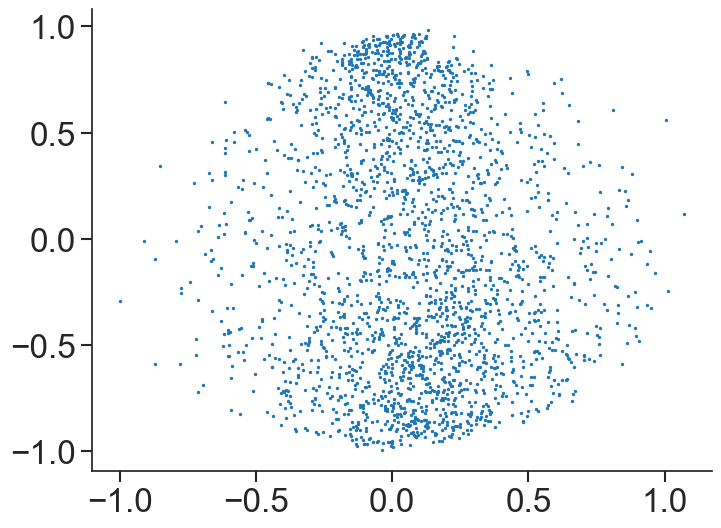

In [6]:
## Building selectivity matrix

plt.figure(figsize=(8,6))
m = res[np.argmax(reg_scores)]
S = m['Ridge'].coef_.T

plt.scatter(S[0,:],S[5,:], s = 2)

### 3D visualization

In [14]:
## Function for 3D visualization of population representations

def threeD_plot(d,shape=(1,1),hyperplans = [],curves = []) :
    
    """ Generates 3D plots to visualize data points in some space for each label and animal
    params: data_files : Files/Animals to plot
    shape : Need to match the number of animals (i.e len(data_files))
    hyperplans : List of hyperplans to plot. Must be of shape (len(data_files) by 2) first element correspond to the hyperplan offset. Second element to the hyperplan normal vector.
    curves : List of curves to plot. Must be of shape(len(data_files) by number of curves by number of components in the space)
    """
    pv.set_jupyter_backend('client')
    p = pv.Plotter(shape=shape, window_size = (1000,500))
    p.set_background('white')
    
    GNG_trials = d['Context'] == 0
    LR_trials = d['Context'] == 1
    t_idx = produce_trial_index(d)
    

    go_hit_idx = t_idx['Go / Go : Hit']
    nogo_error_idx = t_idx['Go / Nogo : Miss']

    nogo_hit_idx = t_idx['NoGo / NoGo : CR']
    go_error_idx =  t_idx['NoGo / Go : FA']


    left_hit_idx =  t_idx['Left / Left']
    snooze_left_idx = t_idx['Left / Snooze']
    left_error_idx = t_idx['Left / Right']

    right_hit_idx = t_idx['Right / Right']
    right_error_idx = t_idx['Right / Left']
    snooze_right_idx =  t_idx['Right / Snooze']
    
    D = np.stack(d['Spike rate'])
    D = standardize(D)
    M = pca1.transform(D)
    
    
    pcs_numbers = [0,2,3]
    
    M = M[:,pcs_numbers]
    
    #M ,pca = PCA_decomposition(d, return_model=True)

    p.subplot(0,0)
    
    p.set_position(np.mean(M[GNG_trials,:3],axis=0))

    #----- This block generates the sphere for each trial label and render them in the 3D plot----
    radius = 0.15
    
    go_hit_spheres = [pv.Sphere(center = M[go_hit_idx][i,:3], radius = radius) for i in range(np.shape(M[go_hit_idx])[0])]
    nogo_hit_spheres = [pv.Sphere(center = M[nogo_hit_idx][i,:3], radius = radius) for i in range(np.shape(M[nogo_hit_idx])[0])]

    go_error_spheres = [pv.Sphere(center = M[go_error_idx][i,:3], radius = radius) for i in range(np.shape(M[go_error_idx])[0])]
    nogo_error_spheres = [pv.Sphere(center = M[nogo_error_idx][i,:3], radius = radius) for i in range(np.shape(M[nogo_error_idx])[0])]

    right_spheres = [pv.Sphere(center = M[right_hit_idx][i,:3], radius = radius) for i in range(np.shape(M[right_hit_idx])[0])]
    left_spheres = [pv.Sphere(center = M[left_hit_idx][i,:3], radius = radius) for i in range(np.shape(M[left_hit_idx])[0])]

    right_error_spheres = [pv.Sphere(center = M[right_error_idx][i,:3], radius = radius) for i in range(np.shape(M[right_error_idx])[0])]
    left_error_spheres = [pv.Sphere(center = M[left_error_idx][i,:3], radius = radius) for i in range(np.shape(M[left_error_idx])[0])]

    snooze_right_spheres = [pv.Sphere(center = M[snooze_right_idx][i,:3], radius = radius) for i in range(np.shape(M[snooze_right_idx])[0])]
    snooze_left_spheres = [pv.Sphere(center = M[snooze_left_idx][i,:3], radius = radius) for i in range(np.shape(M[snooze_left_idx])[0])]
    
    
    for go_hit_sphere in go_hit_spheres :
        p.add_mesh(go_hit_sphere, color='green', opacity = 1)    

    for nogo_hit_sphere in nogo_hit_spheres :
        p.add_mesh(nogo_hit_sphere, color='grey', opacity = 1)

    for go_error_sphere in go_error_spheres :
        p.add_mesh(go_error_sphere, color='black', opacity = 1) 

    for nogo_error_sphere in nogo_error_spheres :
        p.add_mesh(nogo_error_sphere, color='lime', opacity = 1)

    for right_sphere in right_spheres :
        p.add_mesh(right_sphere, color='blue', opacity = 1)

    for left_sphere in left_spheres :
        p.add_mesh(left_sphere, color='red', opacity = 1)
    """
    for right_error_sphere in right_error_spheres :
        p.add_mesh(right_error_sphere, color='cyan', opacity = 1)

    for left_error_sphere in left_error_spheres :
        p.add_mesh(left_error_sphere, color='lightpink', opacity = 1)
    """
    
    for snooze_right_sphere in snooze_right_spheres :
        p.add_mesh(snooze_right_sphere, color='cyan', opacity = 1)

    for snooze_left_sphere in snooze_left_spheres :
        p.add_mesh(snooze_left_sphere, color='lightpink', opacity = 1)

    
    #-----END------

    #Plot the hyperplans if they have been given in the function call
    if len(hyperplans) > 0 :
        print('OK')
        hyperplan = hyperplans[c]
        p.add_mesh(pv.Plane(center=hyperplan[0],direction=hyperplan[1:],i_size=15,j_size=15),color='brown',opacity=0.1)



    #Plot the curves if they have been given in the function call
    if np.shape(curves)[0] > 0 :
        print('OK')
        curve_set = curves[:,:]
        a = 0
        colors = ['orange','gold','orange','gold']
        for curve in curve_set :
            print(a)
            if a < 2 :
                offset = np.mean(M[GNG_trials,:3],axis=0)
            if a >= 2 :
                offset = np.mean(M[LR_trials,:3],axis=0)
            p.add_mesh(pv.Line(offset - 6*curve[pcs_numbers]/np.linalg.norm(curve[pcs_numbers]),offset + 6*curve[pcs_numbers]/np.linalg.norm(curve[pcs_numbers])),color=colors[a], line_width=3)
            a+=1


    p.set_position(np.array([40,0,0]))
    p.show()
        

In [16]:
threeD_plot(merged_data,curves=pca1.transform(S[[0,1,2,3],:]))

OK
0
1
2
3


Widget(value='<iframe src="http://localhost:55580/index.html?ui=P_0x161d3cb60_0&reconnect=auto" class="pyvista…

### ePAIRS

In [18]:
from scipy.stats import pearsonr
from tqdm.auto import tqdm

def compute_PAIRS(S,k=2) :
    """Method computing angle with nearest neighbors (k) distribution"""
    sel_dist = np.zeros((np.shape(S)[1],np.shape(S)[1]))

    for i in tqdm(range(np.shape(S)[1])):
        for j in range(i,np.shape(S)[1]):
            #sel_dist[i,j] = np.linalg.norm(S[:,i]-S[:,j],ord=2)
            sel_dist[i,j] = 1-np.dot(S[:,j],S[:,i])/(np.linalg.norm(S[:,i],ord=2)*np.linalg.norm(S[:,j],ord=2))  #cosine distance
            sel_dist[j,i] = sel_dist[i,j]

    PAIRS = np.zeros(np.shape(S)[1])
    for ne in range(np.shape(sel_dist)[0]) :
        #neighbor = np.argmin()
        neighbors = np.argsort(np.concatenate((sel_dist[ne,:ne],np.array([2]),sel_dist[ne,(ne+1):]),axis=0))[:k]
        PAIRS[ne] = np.mean([np.abs(angle_between(S[:,ne],S[:,neighbor])) for neighbor in neighbors])

    return PAIRS

In [20]:
S_centered = np.array([S[:,n]-np.mean(S,axis=1) for n in range(np.shape(S)[1])]).T
PAIRS = compute_PAIRS(S)

  0%|          | 0/2389 [00:00<?, ?it/s]

In [36]:
import statistics

## Computing ePAIRS statistics from random data with same statistics as our data (same mean and covariance matrix) to get a null distribution
random_PAIRS = compute_PAIRS(np.random.multivariate_normal(np.zeros(np.shape(S)[0]), np.cov(S_centered),size=np.shape(S)[1]).T)

PAIRS_stat =  (np.nanmedian(random_PAIRS) - np.nanmedian(PAIRS))/np.nanmedian(random_PAIRS)
PAIRS_effect = (np.nanmedian(random_PAIRS) - np.nanmedian(PAIRS))/np.nanstd(random_PAIRS)

print(PAIRS_stat, PAIRS_effect)

  0%|          | 0/2389 [00:00<?, ?it/s]

0.12908972347781478 0.5550495028031611


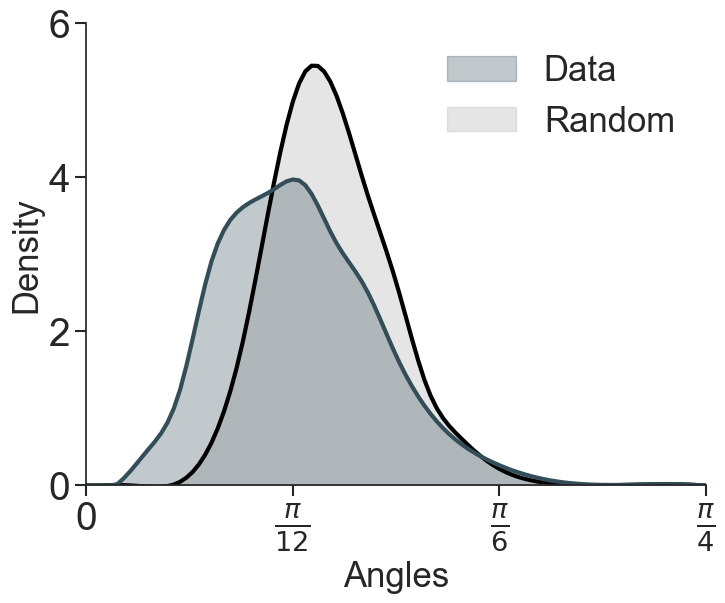

In [253]:
from scipy.optimize import curve_fit 
from scipy.interpolate import splrep, splev

plt.figure(figsize=(8,6))

nb_bin = 20
bin_v = np.array([(k+0.5)*np.pi/(4*nb_bin) for k in range(0,nb_bin)])


h2 = plt.hist(random_PAIRS*np.pi/180,bins=nb_bin,density=True, alpha = 0.65,color='#AAAAAA',label='Random', range=(0,np.pi/4),edgecolor = "black")
h1 = plt.hist(PAIRS*np.pi/180,bins=nb_bin,density=True, alpha = 0.65,color='#334E58',label='Data', range=(0,np.pi/4),edgecolor = "black")

plt.cla()


spl_data = splrep(h1[1], list(h1[0]) + [0], s=0.01, per=False)
spl_random = splrep(h2[1], list(h2[0]) + [0], s=0.01, per=False)
x = np.linspace(0, np.pi/4, 100)
y_data = splev(x, spl_data)
y_random = splev(x, spl_random)


plt.plot(x, y_random, color='black',linewidth=3)
plt.fill_between(x,y1=0,y2=y_random,color='#AAAAAA',alpha=0.3,label="Random")

plt.plot(x,np.maximum(0,y_data),color='#334E58',linewidth=3)
plt.fill_between(x,y1=0,y2=np.maximum(0,y_data),color='#334E58',alpha=0.3,label="Data")

def Gauss(x, A, B, C): 
    y = A*np.exp(-1*B*(x-C)**2) 
    return y 

try :
    parameters, covariance = curve_fit(Gauss, bin_v, h2[0]) 
      
    fit_A_random = parameters[0] 
    fit_B_random = parameters[1]
    fit_C_random = parameters[2]
    
    fit_y_random = Gauss(bin_v, fit_A_random, fit_B_random, fit_C_random)  

    plt.plot(bin_v,fit_y_random,color='black',alpha=0.7,linewidth=3)
except :
    pass


plt.legend(frameon=False,fontsize=25,reverse=True)

plt.xlim((0,np.pi/4))
plt.ylim(0,6)
plt.xticks([0,np.pi/12,np.pi/6,np.pi/4],['0',r'$\frac{\pi}{12}$',r'$\frac{\pi}{6}$',r'$\frac{\pi}{4}$'],fontsize=28)
plt.yticks([0,2,4,6],fontsize=28)
plt.xlabel('Angles')
plt.ylabel('Density')

plt.savefig('Plots/SVG/ePAIRS.SVG', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/ePAIRS.PNG', dpi = 300,bbox_inches='tight')

In [ ]:
## Reproducing tests with different null distributions
r_PAIRS = [compute_PAIRS(np.random.multivariate_normal(np.zeros(np.shape(S)[0]), np.cov(S_centered),size=np.shape(S)[1]).T)\
           for _ in range(200)]

In [215]:
from itertools import combinations

r_couples = list(combinations(r_PAIRS, 2))

r_stats = []
r_effects = []
for couple in r_couples :
    r_stats.append((np.nanmedian(couple[1]) - np.nanmedian(couple[0]))/np.nanmedian(couple[1]))
    r_effects.append((np.nanmedian(couple[1]) - np.nanmedian(couple[0]))/np.nanstd(couple[1]))

print(np.percentile(r_stats,99.999))
print(PAIRS_stat)

print(np.percentile(r_effects,95))
print(PAIRS_effect)

PAIRS_stats = [(np.nanmedian(random) - np.nanmedian(PAIRS))/np.nanmedian(random) for random in r_PAIRS]
PAIRS_effects = [(np.nanmedian(random) - np.nanmedian(PAIRS))/np.nanstd(random) for random in r_PAIRS]


0.031946143115850804
0.12539361836503865
0.06641673933825537
0.5474040879923497


In [202]:
from scipy.stats import mannwhitneyu

PAIRS = PAIRS[~np.isnan(PAIRS)]
random_PAIRS = np.concatenate(r_PAIRS,axis=0)
random_PAIRS = random_PAIRS[~np.isnan(random_PAIRS)]

print(mannwhitneyu(PAIRS, random_PAIRS, nan_policy='omit',alternative='two-sided'))

MannwhitneyuResult(statistic=41671825.0, pvalue=4.1807515822239217e-110)


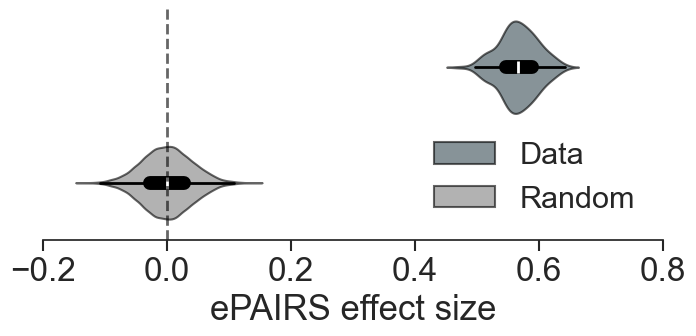

In [238]:
import matplotlib.patches as mpatches

plt.figure(figsize=(8,3))



plot_df = pd.DataFrame({'Type':['Data' for _ in range(len(PAIRS_effects))]+['Random' for _ in range(len(r_effects))],\
                        'Effects': PAIRS_effects+r_effects})

p = sns.violinplot(data = plot_df, y='Type',x='Effects',hue='Type',alpha=0.6,palette=['#334E58','grey'],common_norm=True,\
                    inner_kws=dict(box_width=10, whis_width=2),linecolor='black',linewidth=1.5,orient='h',legend='brief')

plt.legend(fontsize=22)


plt.xlim(-0.2,0.8)
plt.xlabel('ePAIRS effect size')
#plt.ylim(0.45,1.45)

#plt.xticks([-0.2,-0.1,0,0.1,0.2,0.3])
plt.axvline(0,linestyle='--',color='black',alpha=0.6,linewidth=2)


ax = plt.gca()


ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)
colors = ['grey','#334E58']
#violin = plt.violinplot([r_effects,PAIRS_effects,],vert=False)
#violin = plt.violinplot([r_stats,PAIRS_stats],vert=False)

def set_violin_color(violin, colors) :
    for pc,color in zip(violin['bodies'], colors):
        pc.set_facecolor(color)

    violin['cbars'].set_colors(colors)
    violin['cbars'].set_linewidth(3)
    violin['cmins'].set_colors(colors)
    violin['cmins'].set_linewidth(3)
    violin['cmaxes'].set_colors(colors)
    violin['cmaxes'].set_linewidth(3)

labels = ['Data','Random']
patches = []
def add_label(violin):
    c = 0
    for body in violin["bodies"][::-1]:
        color = body.get_facecolor().flatten()
        patches.append((mpatches.Patch(color=color,alpha=0.6), labels[c]))
        c+=1

plt.savefig('Plots/SVG/ePAIRS_effects.SVG', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/ePAIRS_effects.PNG', dpi = 300,bbox_inches='tight')

In [208]:
PAIRS_stats = [(np.nanmedian(random) - np.nanmedian(PAIRS))/np.nanmedian(random) for random in r_PAIRS]
PAIRS_effects = [(np.nanmedian(random) - np.nanmedian(PAIRS))/np.nanstd(random) for random in r_PAIRS]

PAIRS_data = {'Stats':PAIRS_stats, "Effects":PAIRS_effects, "Random stats":r_stats, "Random effects":r_effects}

with open('Models/PAIRS.pickle', 'wb') as handle:
    pickle.dump(PAIRS_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [143]:
with open('Models/PAIRS.pickle', 'rb') as f :
    PAIRS_data = pickle.load(f)
    PAIRS_stats = PAIRS_data['Stats']
    PAIRS_effects = PAIRS_data['Effects']
    r_effects = PAIRS_data['Random effects']

## Structure in selectivity

### Interaction with task selectivity and task participation

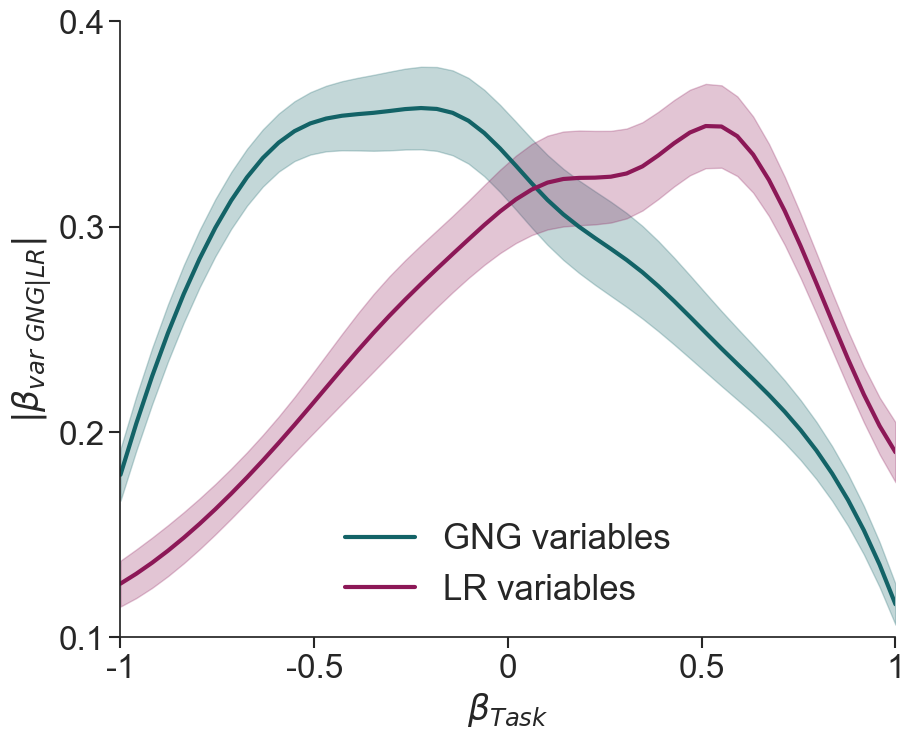

In [8]:
## Binning neurons according to their task selectivity (2*j bins)
j = 5
x_indices = [(k+0.5)/j for k in range(-j,j)]
task_slices = [(S[5,:] >= k/j)&(S[5,:] <= (k+1)/j) for k in range(-j,j)]
slices_numbers = np.array([np.sum(sli) for sli in task_slices])


def GNG_var_pref_score(S_slice) :
    """Task participation in GNG : Mean absolute selectivity to GNG variables"""
    return (np.abs(S_slice[0,:]) + np.abs(S_slice[1,:]))/2

    
def LR_var_pref_score(S_slice) :
    """Task participation in LR : Mean absolute selectivity to LR variables"""
    return (np.abs(S_slice[2,:]) + np.abs(S_slice[3,:]) + np.abs(S_slice[4,:]))/3


def pref_score_quotient(S_slice) :
    """Log ratio between participations to get task specialization"""
    GNG_score = GNG_var_pref_score(S_slice)
    LR_score = LR_var_pref_score(S_slice)

    pref_score_quotient = np.log(LR_score/GNG_score)
    return pref_score_quotient 


GNG_mean_s = np.array([np.mean(GNG_var_pref_score(S[:,task_slices[k]])) for k in range(len(task_slices))])
LR_mean_s = np.array([np.mean(LR_var_pref_score(S[:,task_slices[k]])) for k in range(len(task_slices))])

GNG_std_s = np.array([np.std(GNG_var_pref_score(S[:,task_slices[k]])) for k in range(len(task_slices))])
LR_std_s = np.array([np.std(LR_var_pref_score(S[:,task_slices[k]])) for k in range(len(task_slices))])

GNG_error_s = GNG_std_s*1.96/np.sqrt(slices_numbers)
LR_error_s = LR_std_s*1.96/np.sqrt(slices_numbers)

quotient_mean_s = np.array([np.mean(pref_score_quotient(S[:,task_slices[k]])) for k in range(len(task_slices))])
quotient_std_s = np.array([np.std(pref_score_quotient(S[:,task_slices[k]])) for k in range(len(task_slices))])
quotient_error_s = quotient_std_s*1.96/np.sqrt(slices_numbers)

interpolate = True
nb_point = 50
if interpolate :
    x_smooth,GNG_mean_s = smooth(x_indices,GNG_mean_s,nb_point)
    x_smooth,LR_mean_s = smooth(x_indices,LR_mean_s,nb_point)

    x_smooth,GNG_error_s = smooth(x_indices,GNG_error_s,nb_point)
    x_smooth,LR_error_s = smooth(x_indices,LR_error_s,nb_point)

    x_smooth, quotient_mean_s = smooth(x_indices, quotient_mean_s,nb_point)
    x_smooth, quotient_error_s = smooth(x_indices, quotient_error_s,nb_point)

    x_indices = x_smooth


fig, ax1 = plt.subplots(figsize=(10,8))

plt.ylim((0.1,0.4))
plt.xlim((-0.9,0.9))
ax1.plot(x_indices, GNG_mean_s,color='#136367',linewidth=3, label='GNG variables')
ax1.fill_between(x_indices, GNG_mean_s - GNG_error_s, GNG_mean_s + GNG_error_s, color = '#136367', alpha = 0.25)

ax1.plot(x_indices, LR_mean_s,color='#8C1857',linewidth=3, label='LR variables')
ax1.fill_between(x_indices, LR_mean_s - LR_error_s, LR_mean_s  + LR_error_s, color = '#8C1857', alpha = 0.25)



plt.xlabel(r'$\beta_{Task}$')
plt.ylabel(r'$|\beta_{var \ GNG|LR}|$')
#ax1.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
ax1.set_yticks([0.1,0.2,0.3,0.4])
plt.xticks([-0.9,-0.45,0,0.45,0.9],[-1,-0.5,0,0.5,1])

plt.legend(frameon=False, loc = 'lower center',fontsize=25)

plot_ratio = False
if plot_ratio :
    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    ax2.set_ylim((-1,1))
    fig.tight_layout()
    
    ax2.spines['right'].set_visible(True)
    
    ax2.plot(x_indices,quotient_mean_s, color = '#2D3047',linewidth=3)
    ax2.fill_between(x_indices, quotient_mean_s - quotient_error_s, quotient_mean_s + quotient_error_s, color = '#2D3047', alpha = 0.15)
    plt.yticks([-1,-0.5,0,0.5,1])
    plt.axhline(0, color='black',alpha=0.2,linestyle='--')
    

#plt.savefig('Plots/PNG/task_participation.PNG', dpi = 300, bbox_inches='tight')
#plt.savefig('Plots/SVG/task_participation.SVG', dpi = 300, bbox_inches='tight')

"\nplt.savefig('Plots/PNG/task_specialization.PNG', dpi = 300, bbox_inches='tight')\nplt.savefig('Plots/SVG/task_specialization.SVG', dpi = 300, bbox_inches='tight')\n"

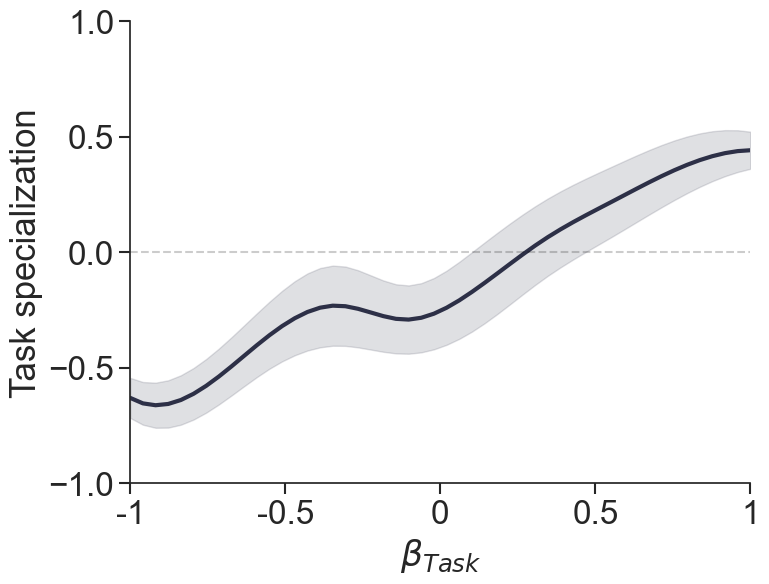

In [20]:
plt.figure(figsize=(8,6))

plt.plot(x_indices,quotient_mean_s, color='#2D3047',linewidth=3)
plt.fill_between(x_indices, quotient_mean_s - quotient_error_s, quotient_mean_s + quotient_error_s, color = '#2D3047', alpha = 0.15)

plt.xlim((-0.9,0.9))
plt.yticks([-1,-0.5,0,0.5,1])
plt.axhline(0, color='black',alpha=0.2,linestyle='--')
plt.xticks([-0.9,-0.45,0,0.45,0.9],[-1,-0.5,0,0.5,1])
plt.ylabel("Task specialization")
plt.xlabel(r'$\beta_{Task}$')


"""
plt.savefig('Plots/PNG/task_specialization.PNG', dpi = 300, bbox_inches='tight')
plt.savefig('Plots/SVG/task_specialization.SVG', dpi = 300, bbox_inches='tight')
"""

In [167]:
spec_tc = [pref_score_quotient(S[:,task_slices[k]]) for k in range(len(task_slices))]

pickle_data = {'GNG': [GNG_mean_s, GNG_std_s], 'LR': [LR_mean_s, LR_std_s],\
               'Log ratio': [quotient_mean_s, quotient_error_s, spec_tc], 'Xs' : x_indices}

# Store data (serialize)
with open('Models/sel_analysis.pickle', 'wb') as handle:
    pickle.dump(pickle_data, handle, protocol=pickle.HIGHEST_PROTOCOL)


#### Decompose regressors

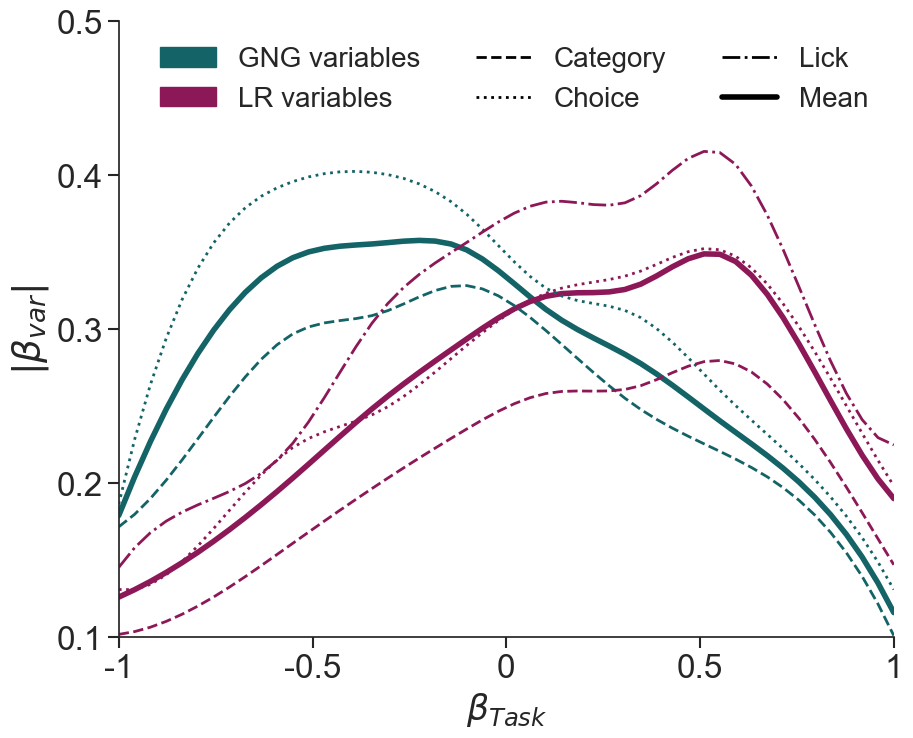

In [253]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

## We decompose here the contribution of each regressor in the task participation scores to see if a task variable drives the effect.
## We found the same pattern for each task variables supporting an increase of neuron representation ability for a broad range of variables in their preferred task.


task_slices = [(S[5,:] >= k/5)&(S[5,:] <= (k+1)/5) for k in range(-5,5)]
slices_numbers = np.array([np.sum(sli) for sli in task_slices])
x_indices = [(k+0.5)/5 for k in range(-5,5)]

def GNG_var_pref_score(S_slice) :
    return (np.abs(S_slice[0,:]) + np.abs(S_slice[1,:]))/2

    
def LR_var_pref_score(S_slice) :
    return (np.abs(S_slice[2,:]) + np.abs(S_slice[3,:]) + np.abs(S_slice[4,:]))/3



GNG_mean_s = np.array([np.mean(GNG_var_pref_score(S[:,task_slices[k]])) for k in range(len(task_slices))])
LR_mean_s = np.array([np.mean(LR_var_pref_score(S[:,task_slices[k]])) for k in range(len(task_slices))])

GNG_std_s = np.array([np.std(GNG_var_pref_score(S[:,task_slices[k]])) for k in range(len(task_slices))])
LR_std_s = np.array([np.std(LR_var_pref_score(S[:,task_slices[k]])) for k in range(len(task_slices))])

GNG_error_s = GNG_std_s*1.96/np.sqrt(slices_numbers)
LR_error_s = LR_std_s*1.96/np.sqrt(slices_numbers)

GNG_cat_s = np.array([np.mean(np.abs(S[0,task_slices[k]]),axis=0) for k in range(len(task_slices))])
LR_cat_s = np.array([np.mean(np.abs(S[2,task_slices[k]]),axis=0) for k in range(len(task_slices))])

GNG_choice_s = np.array([np.mean(np.abs(S[1,task_slices[k]]),axis=0) for k in range(len(task_slices))])
LR_choice_s = np.array([np.mean(np.abs(S[3,task_slices[k]]),axis=0) for k in range(len(task_slices))])

LR_lick_s = np.array([np.mean(np.abs(S[4,task_slices[k]]),axis=0) for k in range(len(task_slices))])

interpolate = True
nb_point = 50
if interpolate :
    x_smooth,GNG_mean_s = smooth(x_indices,GNG_mean_s,nb_point)
    x_smooth,LR_mean_s = smooth(x_indices,LR_mean_s,nb_point)

    x_smooth,GNG_error_s = smooth(x_indices,GNG_error_s,nb_point)
    x_smooth,LR_error_s = smooth(x_indices,LR_error_s,nb_point)


    x_smooth,GNG_cat_s = smooth(x_indices,GNG_cat_s,nb_point)
    x_smooth,LR_cat_s = smooth(x_indices,LR_cat_s,nb_point)

    x_smooth,GNG_choice_s = smooth(x_indices,GNG_choice_s,nb_point)
    x_smooth,LR_choice_s = smooth(x_indices,LR_choice_s,nb_point)
    
    x_smooth,LR_lick_s = smooth(x_indices,LR_lick_s,nb_point)

    x_indices = x_smooth


fig, ax1 = plt.subplots(figsize=(10,8))

plt.ylim((0.1,0.5))
plt.xlim((-0.9,0.9))
ax1.plot(x_indices, GNG_mean_s,color='#136367',linewidth=4, label='GNG variables')

ax1.plot(x_indices, LR_mean_s,color='#8C1857',linewidth=4, label='LR variables')

ax1.plot(x_indices, GNG_cat_s,color='#136367',linewidth=2,linestyle='--')
ax1.plot(x_indices, GNG_choice_s,color='#136367',linewidth=2,linestyle='dotted')

ax1.plot(x_indices, LR_cat_s,color='#8C1857',linewidth=2,linestyle='--')
ax1.plot(x_indices, LR_choice_s,color='#8C1857',linewidth=2,linestyle='dotted')
ax1.plot(x_indices, LR_lick_s,color='#8C1857',linewidth=2,linestyle='-.')

plt.xlabel(r'$\beta_{Task}$')
plt.ylabel(r'$|\beta_{var}|$',fontsize=27)
ax1.set_yticks([0.1,0.2,0.3,0.4,0.5])
plt.xticks([-0.9,-0.45,0,0.45,0.9],[-1,-0.5,0,0.5,1])


patch_GNG = mpatches.Patch(color='#136367', label='GNG variables')   
patch_LR = mpatches.Patch(color='#8C1857', label='LR variables') 

line_cat = Line2D([0], [0], label='Category', color='black',linestyle='--',linewidth=2)
line_choice = Line2D([0], [0], label='Choice', color='black',linestyle='dotted',linewidth=2)
line_lick = Line2D([0], [0], label='Lick', color='black',linestyle='-.',linewidth=2)

line_mean = Line2D([0], [0], label='Mean', color='black',linewidth=4)

handles = [patch_GNG, patch_LR, line_cat, line_choice, line_lick,line_mean]

plt.legend(handles=handles,ncol=3,fontsize=20)


plt.savefig('Plots/PNG/task_participation_decomposed.PNG', dpi = 300, bbox_inches='tight')
plt.savefig('Plots/SVG/task_participation_decomposed.SVG', dpi = 300, bbox_inches='tight')

### Category-Choice mixing score

"\nplt.savefig('Plots/PNG/mixing_score_hybrid.PNG', dpi = 300, bbox_inches='tight')\nplt.savefig('Plots/SVG/mixing_score_hybrid.SVG', dpi = 300, bbox_inches='tight')\n"

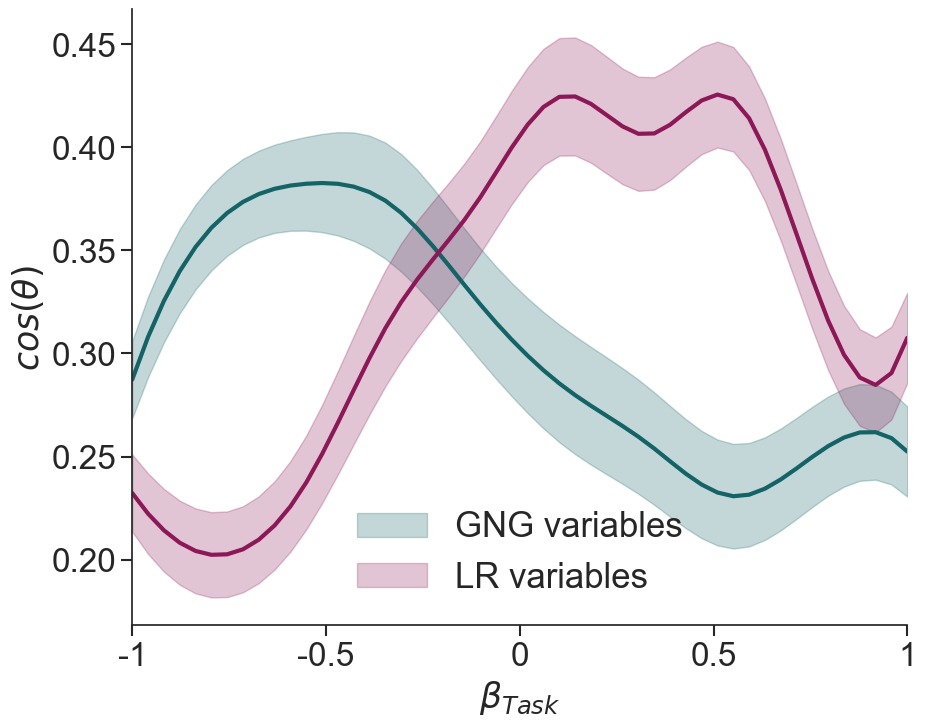

In [46]:
from scipy.stats import pearsonr

j = 5
x_indices = [(k+0.5)/j for k in range(-j,j)]

task_slices = [(S[5,:] >= k/j)&(S[5,:] <= (k+1)/j) for k in range(-j,j)]
slices_numbers = np.array([np.sum(sli) for sli in task_slices])



def GNG_mixing_score(S_slice) :
    return np.abs(np.array([pearsonr(S_slice[:,k],np.array([1,1,0,0,0,0,0]))[0] for k in range(np.shape(S_slice)[1])]))

def LR_mixing_score(S_slice) :
    return np.abs(np.array([pearsonr(S_slice[:,k],np.array([0,0,1,1,0,0,0]))[0] for k in range(np.shape(S_slice)[1])]))

GNG_mean_mixing = np.array([np.mean(GNG_mixing_score(S[:,task_slices[k]])) for k in range(len(task_slices))])
GNG_std_mixing = np.array([np.std(GNG_mixing_score(S[:,task_slices[k]])) for k in range(len(task_slices))])
GNG_error_mixing = 2*GNG_std_mixing/np.sqrt(slices_numbers)

LR_mean_mixing = np.array([np.mean(LR_mixing_score(S[:,task_slices[k]])) for k in range(len(task_slices))])
LR_std_mixing = np.array([np.std(GNG_mixing_score(S[:,task_slices[k]])) for k in range(len(task_slices))])
LR_error_mixing = 2*LR_std_mixing/np.sqrt(slices_numbers)

interpolate = True
nb_point = 50
if interpolate :
    x_smooth,GNG_mean_mixing = smooth(x_indices,GNG_mean_mixing,nb_point)
    x_smooth,LR_mean_mixing = smooth(x_indices,LR_mean_mixing,nb_point)

    x_smooth,GNG_error_mixing = smooth(x_indices,GNG_error_mixing,nb_point)
    x_smooth,LR_error_mixing = smooth(x_indices,LR_error_mixing,nb_point)


    x_indices = x_smooth



plt.figure(figsize=(10,8))

plt.plot(x_indices, GNG_mean_mixing ,color='#136367',linewidth=3)
plt.plot(x_indices, LR_mean_mixing ,color='#8C1857',linewidth=3)

plt.fill_between(x_indices, GNG_mean_mixing - GNG_error_mixing, GNG_mean_mixing  + GNG_error_mixing, color='#136367', alpha = 0.25, label='GNG variables')
plt.fill_between(x_indices, LR_mean_mixing - LR_error_mixing, LR_mean_mixing  + LR_error_mixing, color = '#8C1857', alpha = 0.25, label='LR variables')
plt.xlabel(r'$\beta_{Task}$')
plt.ylabel(r'$cos(\theta)$')
plt.legend(frameon=False,loc='lower center',fontsize=25)

plt.xlim(-0.9,0.9)
plt.xticks([-0.9,-0.45,0,0.45,0.9],[-1,-0.5,0,0.5,1])
#plt.ylim(0.15,0.46)
#plt.yticks([0.15,0.3,0.45])

"""
plt.savefig('Plots/PNG/mixing_score.PNG', dpi = 300, bbox_inches='tight')
plt.savefig('Plots/SVG/mixing_score.SVG', dpi = 300, bbox_inches='tight')
"""

## Activity variance with respect to task selectivity

### Inter-condition variance

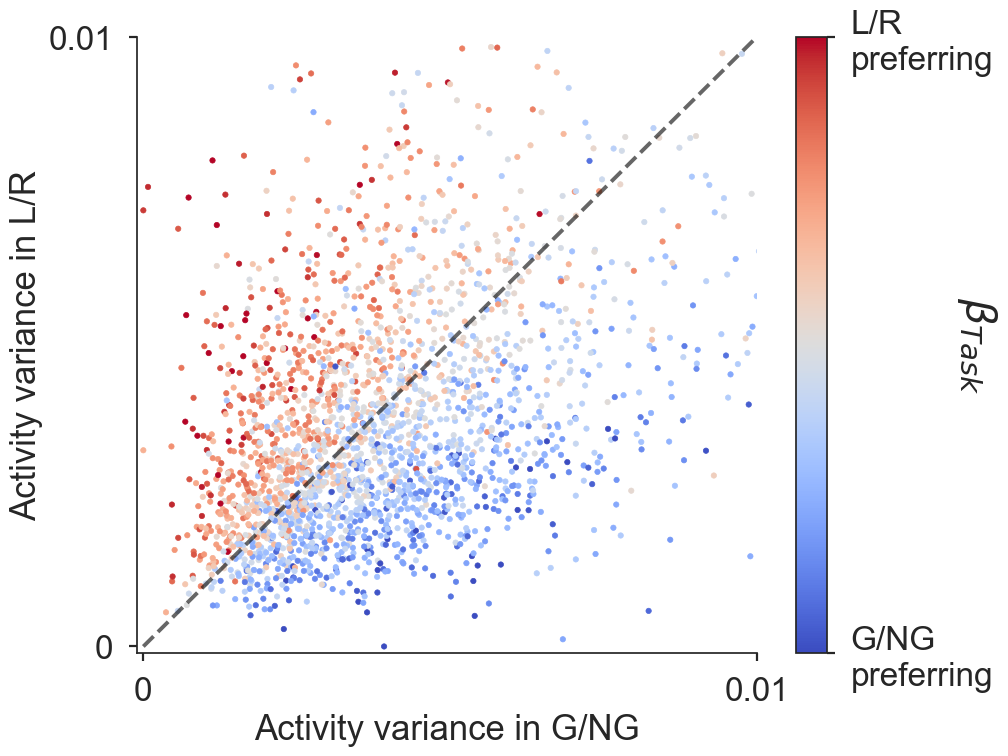

In [270]:
plt.figure(figsize=(10,8))

M = np.stack(merged_data['Spike rate'])
t_GNG = merged_data['Context'] == 0
t_LR = merged_data['Context'] == 1

var_GNG = np.std(M[t_GNG,:],axis=0)
var_LR = np.std(M[t_LR,:],axis=0)
plt.scatter(var_GNG,var_LR,c=np.arctanh(S[5,:]),cmap='coolwarm',vmin=-1.7,vmax=1.7,s=15)
cbar=plt.colorbar(ticks=[-1.7,1.7])
cbar.ax.set_yticklabels(['G/NG\npreferring', 'L/R\npreferring'])
cbar.set_label(r'$\beta_{Task}$',rotation=270,fontsize=30)
plt.xlim((-0.0001,0.01))
plt.ylim((-0.0001,0.01))
plt.plot(np.linspace(0,0.01,100),np.linspace(0,0.01,100),alpha=0.5,color='black',linestyle='--')
plt.xlabel('Activity variance in G/NG')
plt.ylabel('Activity variance in L/R')
plt.xticks([0,0.01],[0,0.01])
plt.yticks([0,0.01],[0,0.01])

plt.savefig('Plots/PNG/variance_notime.PNG', dpi = 300, bbox_inches='tight')
plt.savefig('Plots/SVG/variance_notime.SVG', dpi = 300, bbox_inches='tight')

### Variance across time

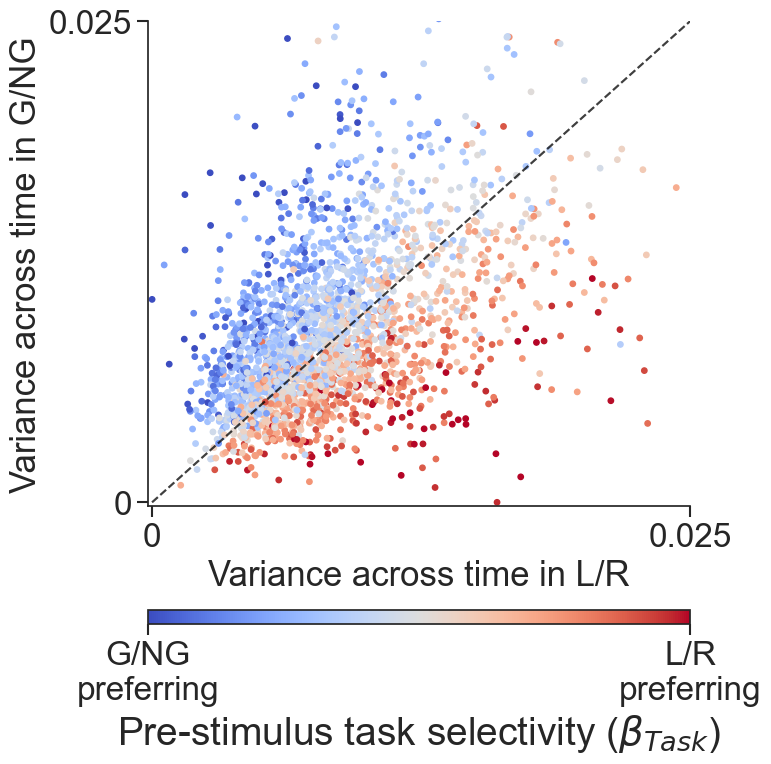

In [20]:
plt.figure(figsize=(7,9))

M = np.stack(merged_data['Trajectory'])

t_GNG = merged_data['Context'] == 0
t_LR = merged_data['Context'] == 1

var_GNG = np.std(M[t_GNG,:,:],axis=(0,1))  # Variance across time of individual neurons in GNG trials
var_LR = np.std(M[t_LR,:,:],axis=(0,1)) # Variance across time of individual neurons in LR trials

vmin,vmax = (-1.7,1.7)

plt.scatter(var_LR,var_GNG,c=np.arctanh(S[5,:]),cmap='coolwarm',vmin=vmin,vmax=vmax,s=15)
#plt.scatter(np.abs(S[1,:]),np.abs(S[3,:]),c=np.arctanh(S[5,:]),cmap='coolwarm',vmin=-1.7,vmax=1.7,s=10)
cbar=plt.colorbar(ticks=[vmin,vmax], location='bottom',aspect=40)
cbar.ax.set_xticklabels(['G/NG\npreferring', 'L/R\npreferring'])
cbar.set_label(r'Pre-stimulus task selectivity ($\beta_{Task}$)',rotation=0,fontsize=28)
plt.xlim((-0.0002,0.025))
plt.ylim((-0.0002,0.025))
plt.plot(np.linspace(0,0.025,100),np.linspace(0,0.025,100),alpha=0.5,color='black',linestyle='--')
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),alpha=0.5,color='black',linestyle='--')
#plt.xlim((-0.02,1))
#plt.ylim((-0.02,1))

plt.ylabel('Variance across time in G/NG')
plt.xlabel('Variance across time in L/R')
plt.xticks([0,0.025],[0,0.025])
plt.yticks([0,0.025],[0,0.025])


plt.savefig('Plots/PNG/variance_time.PNG', dpi = 300, bbox_inches='tight')
plt.savefig('Plots/SVG/variance_time.SVG', dpi = 300, bbox_inches='tight')

## PSTHs

In [96]:
## Selecting individual neurons to draw PSTHs

array = S[5,:]

flat_indices = np.argpartition(array.flatten(), -30)[-30:]
sorted_indices = flat_indices[np.argsort(array.flatten()[flat_indices])[::-1]]
indices = np.unravel_index(sorted_indices, array.shape)
top_10_values = array[indices]

indices

(array([ 729, 1088, 1255, 1194,  682, 1433,  495,  176,  243,  325, 1239,
        1149,  304, 1751, 1646,  313, 1096,  139,  991, 2157,  664, 1167,
         446, 1382,  792, 1305, 2321, 1190,  563, 1396]),)

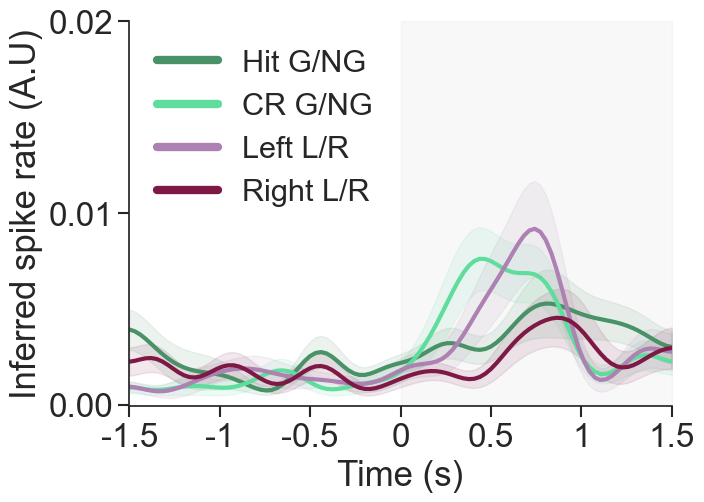

In [307]:
from scipy.ndimage import gaussian_filter1d

plt.figure(figsize=(7,5))
cell = 1115 #404, 1255, 1875, 1115
M = np.stack(merged_data['Trajectory'])
T = np.shape(M)[1]

hit_trials = merged_data['Label'] == 1
cr_trials = merged_data['Label'] == 3

left_trials = merged_data['Label'] == 5
right_trials = merged_data['Label'] == 8

psths_hit = M[hit_trials,:,cell]
psths_cr = M[cr_trials,:,cell]

psths_left = M[left_trials,:,cell]
psths_right = M[right_trials,:,cell]


mean_psth_hit = np.mean(psths_hit,axis=0)
mean_psth_cr = np.mean(psths_cr,axis=0)

mean_psth_left = np.mean(psths_left,axis=0)
mean_psth_right = np.mean(psths_right,axis=0)

psth_hit_error = np.std(psths_hit,axis=0)/np.sqrt(len(psths_hit))
psth_cr_error = np.std(psths_cr,axis=0)/np.sqrt(len(psths_cr))

psth_left_error = np.std(psths_left,axis=0)/np.sqrt(len(psths_left))
psth_right_error = np.std(psths_right,axis=0)/np.sqrt(len(psths_right))


interpolate = True
nb_point = 100
sig = 3
if interpolate :
    _,mean_psth_hit = gaussian_filter1d(smooth(range(T),mean_psth_hit,nb_point),sigma=sig)
    _,mean_psth_cr = gaussian_filter1d(smooth(range(T),mean_psth_cr ,nb_point),sigma=sig)

    _,mean_psth_left = gaussian_filter1d(smooth(range(T),mean_psth_left ,nb_point),sigma=sig)
    _,mean_psth_right = gaussian_filter1d(smooth(range(T),mean_psth_right ,nb_point),sigma=sig)

    _,psth_hit_error = gaussian_filter1d(smooth(range(T),psth_hit_error ,nb_point),sigma=sig)
    _,psth_cr_error = gaussian_filter1d(smooth(range(T),psth_cr_error ,nb_point),sigma=sig)

    _,psth_left_error = gaussian_filter1d(smooth(range(T),psth_left_error ,nb_point),sigma=sig)
    _,psth_right_error = gaussian_filter1d(smooth(range(T),psth_right_error ,nb_point),sigma=sig)


    T=nb_point
    
lw=3

plt.plot(mean_psth_hit,color='#499167',label='Hit G/NG',linewidth=lw)
plt.plot(mean_psth_cr,color='#5FDD9D',label='CR G/NG',linewidth=lw)

plt.fill_between(range(T),mean_psth_hit - psth_hit_error,mean_psth_hit + psth_hit_error,alpha=0.1,color='#499167')

plt.fill_between(range(T),mean_psth_cr - psth_cr_error,mean_psth_cr + psth_cr_error,alpha=0.1,color='#5FDD9D')

plt.plot(mean_psth_left,color='#AD81B1',label='Left L/R',linewidth=lw)
plt.plot(mean_psth_right,color='#7E1946',label='Right L/R',linewidth=lw)

plt.fill_between(range(T),mean_psth_left - psth_left_error,mean_psth_left + psth_left_error,alpha=0.1,color='#AD81B1')

plt.fill_between(range(T),mean_psth_right - psth_right_error,mean_psth_right + psth_right_error,alpha=0.1,color='#7E1946')

plt.xlabel('Time (s)')
plt.xticks(np.linspace(0,T-1,7),[-1.5,-1,-0.5,0,0.5,1,1.5])

y_max = 0.02
plt.ylim(-0.0001,y_max)
plt.xlim((0,T-1))
plt.yticks([0,y_max/2,y_max])

plt.fill_between([T//2-1/2,T-1],0,y_max,color='grey',alpha=0.05)

plt.ylabel('Inferred spike rate (A.U)')

leg = plt.legend(frameon=False,loc='upper left',fontsize=22)

leg.get_lines()[0].set_linewidth(6)
leg.get_lines()[1].set_linewidth(6)
leg.get_lines()[2].set_linewidth(6)
leg.get_lines()[3].set_linewidth(6)


plt.savefig('Plots/PNG/PSTHs/psth_'+ str(cell) + '.PNG', dpi = 300, bbox_inches='tight')
plt.savefig('Plots/SVG/PSTHs/psth_'+ str(cell) + '.SVG', dpi = 300, bbox_inches='tight')

## Heatmaps

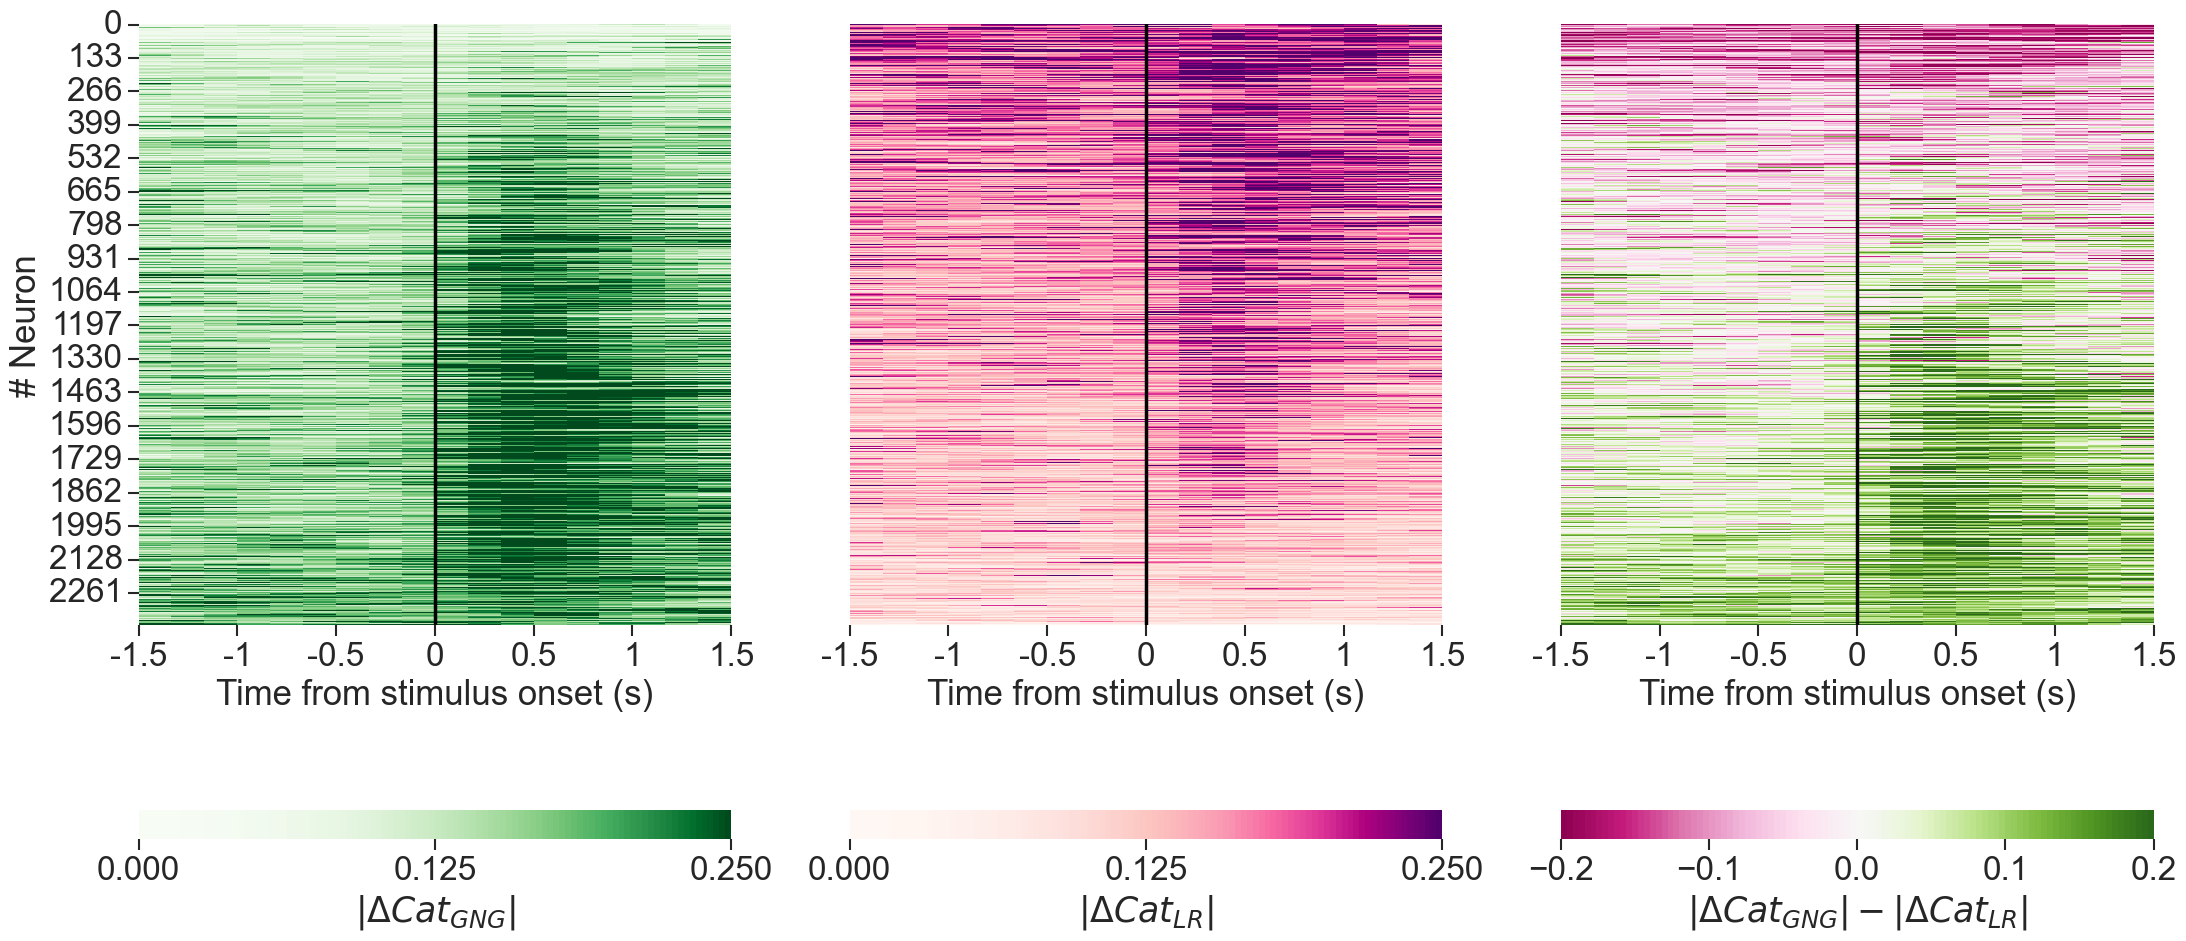

In [198]:
from scipy.ndimage import gaussian_filter

M = np.stack(merged_data['Trajectory'])
s1,s2,s3 = np.shape(M)
M = np.resize(M,(s1*s2,s3))
M = standardize(M)
M = np.resize(M,(s1,s2,s3))

cat1_GNG = (merged_data['Category ID'] == 1)&(merged_data['Context'] == 0)
cat2_GNG = (merged_data['Category ID'] == 2)&(merged_data['Context'] == 0)

cat1_LR = (merged_data['Category ID'] == 1)&(merged_data['Context'] == 1)
cat2_LR = (merged_data['Category ID'] == 2)&(merged_data['Context'] == 1)



M1_GNG = np.mean(M[cat1_GNG],axis=0)[:,np.argsort(-S[5,:])]
M2_GNG = np.mean(M[cat2_GNG],axis=0)[:,np.argsort(-S[5,:])]

M1_LR = np.mean(M[cat1_LR],axis=0)[:,np.argsort(-S[5,:])]
M2_LR = np.mean(M[cat2_LR],axis=0)[:,np.argsort(-S[5,:])]


fig,axs = plt.subplots(1,3,figsize=(26,12))


purple_cm = mpl.colors.ListedColormap(mpl.colormaps['RdPu'](np.array([(i/100)**2 for i in range(100)])))

green_cm = mpl.colors.ListedColormap(mpl.colormaps['Greens'](np.array([(i/100)**2 for i in range(100)])))

delta_cm = mpl.colors.ListedColormap(mpl.colormaps['PiYG'](np.array([0.5*(i/50)**(1/1) for i in range(0,50)]+[0.5+0.5*(i/50)**(1) for i in range(0,50)])))



smooth_sigma = 1

sns.heatmap(gaussian_filter(np.abs(M1_GNG.T - M2_GNG.T),sigma=smooth_sigma),vmin=0,vmax=0.25,ax = axs[0],cmap=green_cm,cbar_kws={"orientation": "horizontal","pad":0.2,'ticks':[0,0.125,0.25],'label': r'$|\Delta Cat_{GNG}|$'})
axs[0].axvline(9,color='black',linewidth=2.5)
sns.heatmap(gaussian_filter(np.abs(M1_LR.T - M2_LR.T),sigma=smooth_sigma),vmin=0,vmax=0.25, ax = axs[1],cmap=purple_cm,cbar_kws={"orientation": "horizontal","pad":0.2,'ticks': [0,0.125,0.25],'label': r'$|\Delta Cat_{LR}|$'})
axs[1].axvline(9,color='black',linewidth=2.5)
sns.heatmap(gaussian_filter(np.abs(M1_GNG.T - M2_GNG.T)-np.abs(M1_LR.T - M2_LR.T),sigma=smooth_sigma),vmin=-0.2,vmax=0.2, ax = axs[2],cmap=delta_cm,cbar_kws={"orientation": "horizontal","pad":0.2,'ticks': [-0.2,-0.1,0,0.1,0.2],'label': r'$|\Delta Cat_{GNG}| - |\Delta Cat_{LR}|$'})
axs[2].axvline(9,color='black',linewidth=2.5)

axs[0].set_ylabel('# Neuron')
"""
axs[0].set_yticks([1,400,800,1200,1600,2000,2389])
colors=[coolwarm_cm(i) for i in np.linspace(0,1,7)]
for ytick, color in zip(axs[0].get_yticks(), colors):
    ytick.set_color(color)
"""
axs[1].set_yticks([])
axs[2].set_yticks([])

axs[0].set_xticks([0,3,6,9,12,15,18],[-1.5,-1,-0.5,0,0.5,1,1.5])
axs[1].set_xticks([0,3,6,9,12,15,18],[-1.5,-1,-0.5,0,0.5,1,1.5])
axs[2].set_xticks([0,3,6,9,12,15,18],[-1.5,-1,-0.5,0,0.5,1,1.5])

axs[0].set_xlabel('Time from stimulus onset (s)')
axs[1].set_xlabel('Time from stimulus onset (s)')
axs[2].set_xlabel('Time from stimulus onset (s)')


plt.savefig('Plots/PNG/heatmaps.PNG', dpi = 300, bbox_inches='tight')
plt.savefig('Plots/SVG/heatmaps.SVG', dpi = 300, bbox_inches='tight')